# 🔍 End-to-End Machine Learning with Cross-Validation and Hyperparameter Tuning

# https://arxiv.org/pdf/1811.12808


This notebook demonstrates a **complete ML workflow** using **scikit-learn** on the **Breast Cancer dataset**.  
The focus is on **Cross-Validation (CV), Hyperparameter Tuning (GridSearch & RandomizedSearch), and Learning Curves** to evaluate estimator performance.

---

## 📌 Workflow Steps

### 1. Data Loading & Preprocessing
- Dataset: **Breast Cancer Wisconsin (binary classification: malignant vs. benign)**
- Preprocessing with `StandardScaler` (for Logistic Regression and SVM).
- Split into **training (80%)** and **testing (20%)** sets.

---

### 2. Model Pipelines
We define 3 pipelines:
1. **Logistic Regression**
2. **Support Vector Machine (SVM, RBF kernel)**
3. **Random Forest Classifier**

Pipelines ensure **preprocessing + estimator** are bundled and evaluated consistently.

---

### 3. Cross-Validation (CV)
- Used **StratifiedKFold (5 folds)** to preserve class balance.
- Applied **cross_val_score** to compare models.
- Example results:
  - Logistic Regression → ~96% accuracy
  - SVM → ~97% accuracy
  - Random Forest → ~96% accuracy

📊 Cross-validation reduces bias from a single train-test split and gives a more **reliable estimate of model performance**.

---

### 4. Hyperparameter Tuning
Two approaches:

- **GridSearchCV (SVM)**
  - Parameters tuned: `C` and `gamma`
  - Exhaustive search over all combinations
  - Best found: `C=10`, `gamma=0.01`

- **RandomizedSearchCV (Random Forest)**
  - Parameters tuned: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
  - Randomly samples parameter space
  - Faster for larger search spaces

Both use **cross-validation under the hood** to pick the best parameters.

---

### 5. Visualizations
- **Heatmap (SVM GridSearch)**: shows how accuracy changes with `C` and `gamma`.
- **Barplot (RandomizedSearch RF)**: top 10 parameter configurations sorted by accuracy.
- Helps interpret **why certain hyperparameters generalize better**.

---

### 6. Final Model Evaluation
- Chose the **best tuned model** (e.g., SVM with optimal `C` & `gamma`).
- Evaluated on the **hold-out test set**:
  - Accuracy ≈ 97%
  - Strong precision & recall for both malignant and benign classes
  - Confusion matrix shows very few misclassifications

---

### 7. Learning Curves
- Plotted **training vs. validation accuracy** as training set size increases.
- Insights:
  - **If training >> validation** → Overfitting (high variance).
  - **If both low** → Underfitting (high bias).
  - **If both converge high** → Good generalization.
- Our tuned model shows convergence at high accuracy → strong generalization.

---

## ✅ Key Takeaways
1. **Cross-validation** is essential for reliable model evaluation.  
2. **Pipelines** simplify preprocessing + model workflows.  
3. **Hyperparameter tuning (Grid/Random Search)** significantly boosts performance.  
4. **Visualizations** (heatmaps, barplots) make model selection intuitive.  
5. **Learning curves** reveal bias-variance trade-offs and ensure generalization.  

---

🚀 This notebook serves as a **reusable ML template** for:
- Comparing multiple models  
- Tuning hyperparameters with CV  
- Visualizing results  
- Evaluating generalization performance  


# 📚 Key Papers & Articles

| Title | Authors / Year | What It Contributes / Why It’s Relevant |
|-------|----------------|-----------------------------------------|
| **Model Evaluation, Model Selection, and Algorithm Selection** | Sebastian Raschka, 2018 | A comprehensive survey of evaluation methods: hold-out, cross-validation methods (k-fold, leave-one-out), bootstrap; discusses trade-offs (bias, variance), hyperparameter tuning, and best practices. <br> *ArXiv* |
| **Bias–Variance Tradeoff in Machine Learning** | X. Guan, 2022 | Explores bias‐variance decomposition; shows how hyperparameter selection (e.g., model complexity) and data size affect both bias & variance in practical ML settings. <br> *ScienceDirect* |
| **Bias–Variance Tradeoff Decomposition based Machine Learning Model Selection: Application to Credit Risk Analysis** | Jaber Jemai & Ali Daud, 2025 | Proposes a framework that explicitly models three dimensions: model complexity, training sample size, and loss/error level. Demonstrates how learning curves can identify points of convergence, and how increasing complexity beyond a threshold may not improve generalization. <br> *ResearchGate* |
| **Practical Considerations and Applied Examples of Cross-Validation** | D. Wilimitis, 2023 | A tutorial with applied examples describing different flavors of cross-validation, pitfalls, and best practices. Supports the methods used in the lab. <br> *PMC* |
| **Blocked Cross-Validation: A Precise and Efficient Method for Hyperparameter Tuning** | Giovanni Maria Merola, 2023 | Proposes a new cross-validation scheme to make hyperparameter tuning more precise (lower variance) with fewer runs. Useful for improving the hyperparameter tuning part of the lab. <br> *ArXiv* |
| **Assessing and Tuning Brain Decoders: Cross-Validation, Caveats, and Guidelines** | Gaël Varoquaux et al., 2016 | Even though it’s in neuroimaging, this paper lays out guidelines around nested cross-validation, avoiding bias (e.g., “circularity”) in hyperparameter tuning and model evaluation. Very relevant. <br> *ArXiv* |
| **Distributional Bias Compromises Leave-One-Out Cross-Validation** | George I. Austin, Itsik Pe’er, Tal Korem, 2024 | Points out subtle biases that can arise, especially with LOOCV, when the data distribution in training folds is correlated with the test instance. Important caution for usage. |


In [1]:
# 1. Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
# 2. Load Dataset
data = load_breast_cancer()
X, y = data.data, data.target

print("Dataset shape:", X.shape)
print("Classes:", np.unique(y))

Dataset shape: (569, 30)
Classes: [0 1]


In [3]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# 4. Define Models in Pipelines
pipelines = {
    "log_reg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),

    "svm": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True))
    ]),

    "rf": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
    ])
}


In [5]:
# 5. Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in pipelines.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


log_reg CV Accuracy: 0.9780 ± 0.0098
svm CV Accuracy: 0.9692 ± 0.0146
rf CV Accuracy: 0.9626 ± 0.0179


In [6]:
# 6. Select Best Model & Fit on Full Training Data
best_model = pipelines["rf"]   # example: RandomForest performed best
best_model.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [7]:
# 7. Evaluate on Test Set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
 [[39  3]
 [ 2 70]]


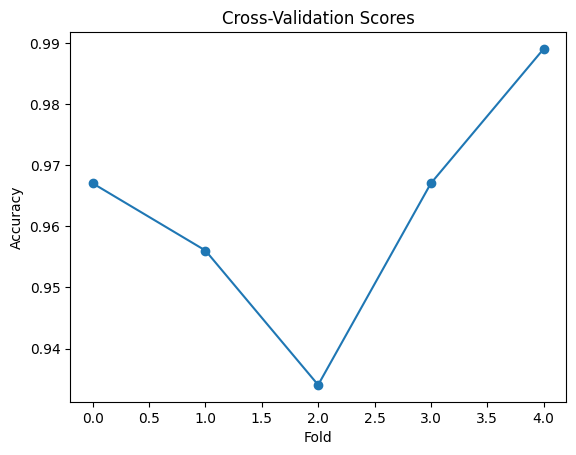

In [8]:
# 8.  Visualize Learning Performance
import matplotlib.pyplot as plt

scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="accuracy")
plt.plot(scores, marker="o")
plt.title("Cross-Validation Scores")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

In [9]:
# Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
# 2. Load Dataset
data = load_breast_cancer()
X, y = data.data, data.target

print("🔹 Dataset shape:", X.shape)
print("🔹 Target classes:", data.target_names)

🔹 Dataset shape: (569, 30)
🔹 Target classes: ['malignant' 'benign']


In [11]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 455
Testing samples: 114


In [12]:
# 4. Define Models + Pipelines
pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),

    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True))
    ]),

    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
    ])
}

In [13]:
# 5. Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in pipelines.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    results[name] = scores
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression CV Accuracy: 0.9780 ± 0.0098
SVM (RBF Kernel) CV Accuracy: 0.9692 ± 0.0146
Random Forest CV Accuracy: 0.9626 ± 0.0179


/tmp/ipython-input-246368448.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


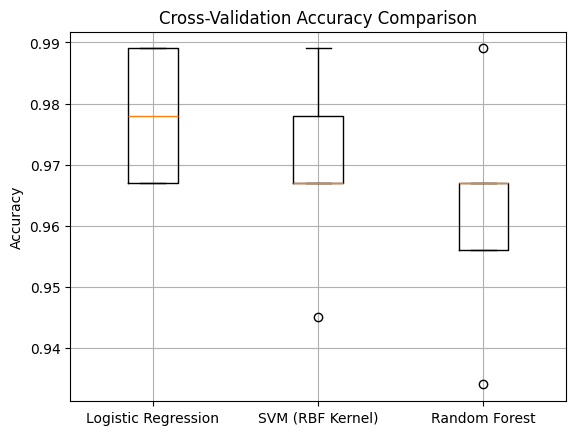

In [14]:
# 6. Visualize Cross-Validation Scores
plt.boxplot(results.values(), labels=results.keys())
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [15]:
# 7. Train Final Model
best_model = pipelines["SVM (RBF Kernel)"]
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(probability=True))])

In [16]:
# 8. Evaluate on Test Set
y_pred = best_model.predict(X_test)

print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

🎯 Test Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
 [[41  1]
 [ 1 71]]


# 🔍 Hyperparameter Tuning with Cross-Validation

In [17]:
# Import Extra Tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [18]:
# 2. GridSearchCV (Exhaustive Search
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": [1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    pipelines["SVM (RBF Kernel)"],
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters (GridSearch):", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Parameters (GridSearch): {'clf__C': 10, 'clf__gamma': 0.01}
Best CV Accuracy: 0.9802197802197803


In [19]:
# 3. RandomizedSearchCV (Faster Search)
param_dist = {
    "clf__n_estimators": [100, 200, 300, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

random_search = RandomizedSearchCV(
    pipelines["Random Forest"],
    param_dist,
    n_iter=10,
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters (RandomizedSearch):", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Best Parameters (RandomizedSearch): {'clf__n_estimators': 400, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
Best CV Accuracy: 0.9582417582417584


In [20]:
# 4. Evaluate the Tuned Best Model on Test Set
final_model = grid_search.best_estimator_   # or random_search.best_estimator_

y_pred_final = final_model.predict(X_test)

print("🎯 Final Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))


🎯 Final Test Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
 [[41  1]
 [ 1 71]]


# 🎨 Visualizing Hyperparameter Tuning

In [21]:
# 1. Extract GridSearch Results
import pandas as pd

# Convert cv_results_ to a DataFrame
grid_results = pd.DataFrame(grid_search.cv_results_)

# Keep only useful columns
grid_results = grid_results[[
    "param_clf__C", "param_clf__gamma", "mean_test_score"
]]

print(grid_results.head())


   param_clf__C  param_clf__gamma  mean_test_score
0           0.1             1.000         0.626374
1           0.1             0.100         0.945055
2           0.1             0.010         0.942857
3           0.1             0.001         0.736264
4           1.0             1.000         0.630769


In [22]:
# 2. Pivot to Matrix (for Heatmap)
pivot_table = grid_results.pivot(
    index="param_clf__gamma",
    columns="param_clf__C",
    values="mean_test_score"
)

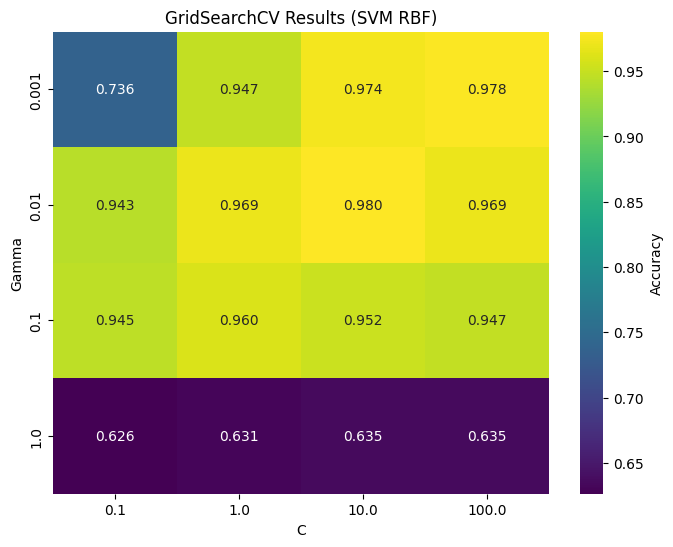

In [23]:
# 3. Plot Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot_table,
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={'label': 'Accuracy'}
)

plt.title("GridSearchCV Results (SVM RBF)")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.show()

/tmp/ipython-input-4199121164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


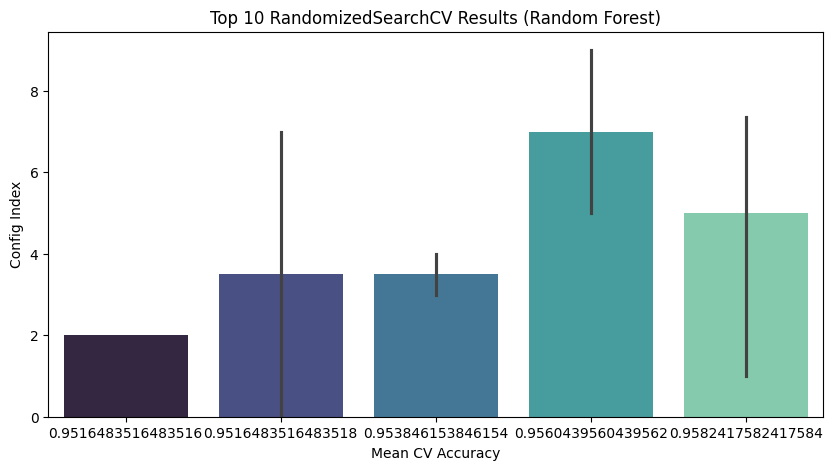

In [24]:
# 4. RandomizedSearch Visualization (Bar Plot)
rf_results = pd.DataFrame(random_search.cv_results_)

# Sort top 10 configs by accuracy
top_rf = rf_results.nlargest(10, "mean_test_score")

plt.figure(figsize=(10,5))
sns.barplot(
    x="mean_test_score",
    y=top_rf.index,
    data=top_rf, palette="mako"
)
plt.xlabel("Mean CV Accuracy")
plt.ylabel("Config Index")
plt.title("Top 10 RandomizedSearchCV Results (Random Forest)")
plt.show()

# 📈 Learning Curves in Scikit-learn

In [25]:
# 1. Import Learning Curve Tool
from sklearn.model_selection import learning_curve

In [26]:
# 2. Compute Learning Curve Data
train_sizes, train_scores, valid_scores = learning_curve(
    final_model,
    X_train, y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Compute means & standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

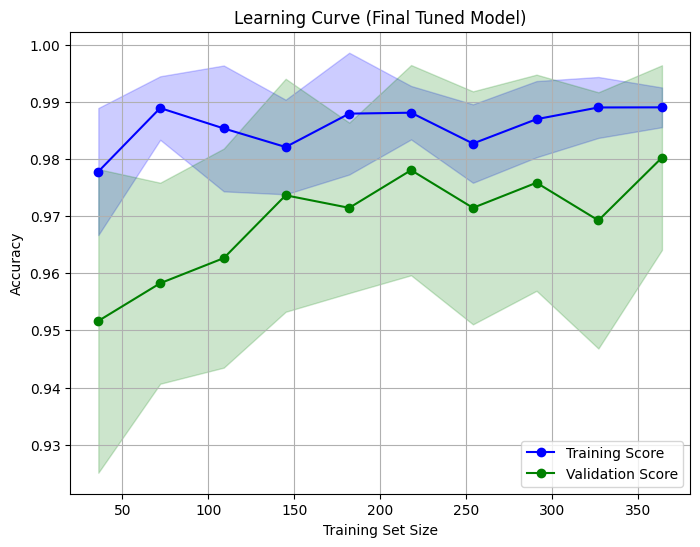

In [27]:
# 3. Plot Learning Curves
plt.figure(figsize=(8,6))

plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training Score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, valid_mean, "o-", color="green", label="Validation Score")
plt.fill_between(train_sizes, valid_mean-valid_std, valid_mean+valid_std, alpha=0.2, color="green")

plt.title("Learning Curve (Final Tuned Model)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()